# Build a classification decision tree

In this notebook we illustrate decision trees in a multiclass classification
problem by using the penguins dataset with 2 features and 3 classes.

For the sake of simplicity, we focus the discussion on the hyperparamter
`max_depth`, which controls the maximal depth of the decision tree.

In [1]:
import pandas as pd

penguins = pd.read_csv("penguins_classification.csv")
culmen_columns = ["Culmen Length (mm)", "Culmen Depth (mm)"]
target_column = "Species"

First, we split the data into two subsets to investigate how trees predict
values based on unseen data.

In [2]:
from sklearn.model_selection import train_test_split

data, target = penguins[culmen_columns], penguins[target_column]
data_train, data_test, target_train, target_test = train_test_split(
    data, target, random_state=0
)

In a previous notebook, we learnt that linear classifiers define a linear
separation to split classes using a linear combination of the input features.
In our 2-dimensional feature space, it means that a linear classifier finds
the oblique lines that best separate the classes. This is still true for
multiclass problems, except that more than one line is fitted. We can use
`DecisionBoundaryDisplay` to plot the decision boundaries learnt by the
classifier.

In [3]:
from sklearn.linear_model import LogisticRegression

linear_model = LogisticRegression()
linear_model.fit(data_train, target_train)

LogisticRegression()

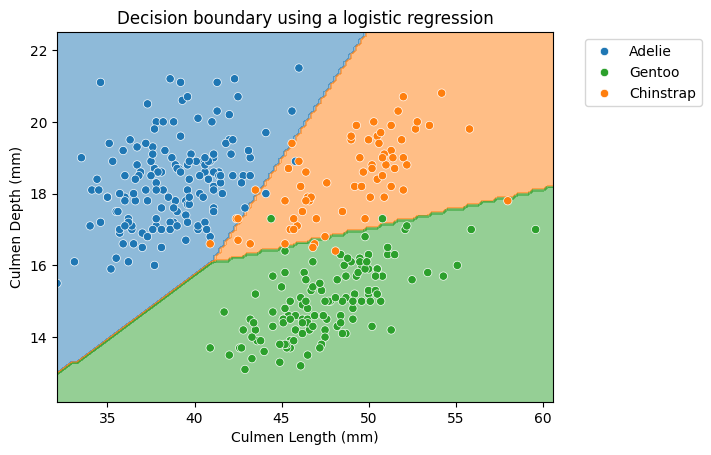

In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from sklearn.inspection import DecisionBoundaryDisplay

tab10_norm = mpl.colors.Normalize(vmin=-0.5, vmax=8.5)
# create a palette to be used in the scatterplot
palette = ["tab:blue", "tab:green", "tab:orange"]

dbd = DecisionBoundaryDisplay.from_estimator(
    linear_model,
    data_train,
    response_method="predict",
    cmap="tab10",
    norm=tab10_norm,
    alpha=0.5,
)
sns.scatterplot(
    data=penguins,
    x=culmen_columns[0],
    y=culmen_columns[1],
    hue=target_column,
    palette=palette,
)
# put the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
_ = plt.title("Decision boundary using a logistic regression")

We see that the lines are a combination of the input features since they are
not perpendicular a specific axis. Indeed, this is due to the model
parametrization that we saw in some previous notebooks, i.e. controlled by the
model's weights and intercept.

Besides, it seems that the linear model would be a good candidate for such
problem as it gives good accuracy.

In [5]:
linear_model.fit(data_train, target_train)
test_score = linear_model.score(data_test, target_test)
print(f"Accuracy of the LogisticRegression: {test_score:.2f}")

Accuracy of the LogisticRegression: 0.98


Unlike linear models, the decision rule for the decision tree is not
controlled by a simple linear combination of weights and feature values.

Instead, the decision rules of trees can be defined in terms of
- the feature index used at each split node of the tree,
- the threshold value used at each split node,
- the value to predict at each leaf node.

Decision trees partition the feature space by considering a single feature at
a time. The number of splits depends on both the hyperparameters and the
number of data points in the training set: the more flexible the
hyperparameters and the larger the training set, the more splits can be
considered by the model.

As the number of adjustable components taking part in the decision rule
changes with the training size, we say that decision trees are non-parametric
models.

Let's now visualize the shape of the decision boundary of a decision tree when
we set the `max_depth` hyperparameter to only allow for a single split to
partition the feature space.

In [5]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth=1)
tree.fit(data_train, target_train)

DecisionTreeClassifier(max_depth=1)

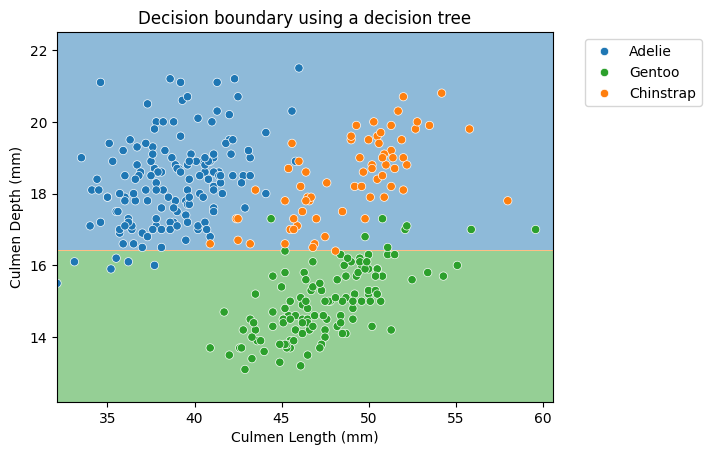

In [6]:
DecisionBoundaryDisplay.from_estimator(
    tree,
    data_train,
    response_method="predict",
    cmap="tab10",
    norm=tab10_norm,
    alpha=0.5,
)
sns.scatterplot(
    data=penguins,
    x=culmen_columns[0],
    y=culmen_columns[1],
    hue=target_column,
    palette=palette,
)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
_ = plt.title("Decision boundary using a decision tree")

The partitions found by the algorithm separates the data along the axis
"Culmen Depth", discarding the feature "Culmen Length". Thus, it highlights
that a decision tree does not use a combination of features when making a
single split. We can look more in depth at the tree structure.

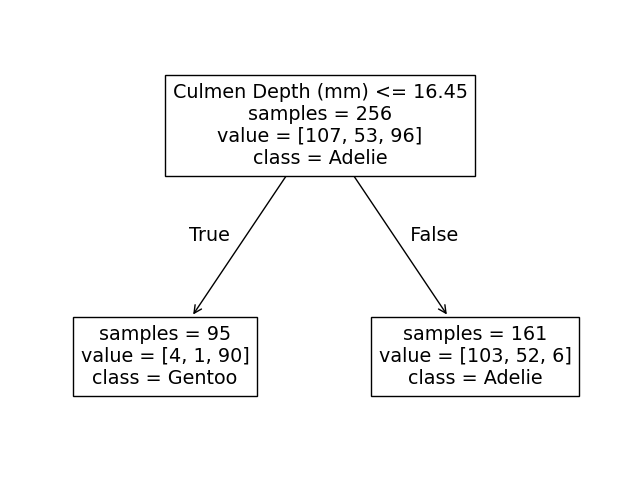

In [7]:
from sklearn.tree import plot_tree

_, ax = plt.subplots(figsize=(8, 6))
_ = plot_tree(
    tree,
    feature_names=culmen_columns,
    class_names=tree.classes_.tolist(),
    impurity=False,
    ax=ax,
)

<div class="admonition tip alert alert-warning">
<p class="first admonition-title" style="font-weight: bold;">Tip</p>
<p class="last">We are using the function <tt class="docutils literal">fig, ax = <span class="pre">plt.subplots(figsize=(8,</span> 6))</tt> to create
a figure and an axis with a specific size. Then, we can pass the axis to the
<tt class="docutils literal">sklearn.tree.plot_tree</tt> function such that the drawing happens in this axis.</p>
</div>

We see that the split was done on the culmen depth feature. The original
dataset was subdivided into 2 sets based on the culmen depth (inferior or
superior to 16.45 mm).

This partition of the dataset minimizes the class diversity in each
sub-partitions. This measure is also known as a **criterion**, and is a
settable parameter.

If we look more closely at the partition, we see that the sample superior to
16.45 belongs mainly to the "Adelie" class. Looking at the values, we indeed
observe 103 "Adelie" individuals in this space. We also count 52 "Chinstrap"
samples and 6 "Gentoo" samples. We can make similar interpretation for the
partition defined by a threshold inferior to 16.45mm. In this case, the most
represented class is the "Gentoo" species.

Let's see how our tree would work as a predictor. Let's start with a case
where the culmen depth is inferior to the threshold.

In [8]:
test_penguin_1 = pd.DataFrame(
    {"Culmen Length (mm)": [0], "Culmen Depth (mm)": [15]}
)
tree.predict(test_penguin_1)

array(['Gentoo'], dtype=object)

The class predicted is the "Gentoo". We can now check what happens if we pass a
culmen depth superior to the threshold.

In [9]:
test_penguin_2 = pd.DataFrame(
    {"Culmen Length (mm)": [0], "Culmen Depth (mm)": [17]}
)
tree.predict(test_penguin_2)

array(['Adelie'], dtype=object)

In this case, the tree predicts the "Adelie" specie.

Thus, we can conclude that a decision tree classifier predicts the most
represented class within a partition.

During the training, we have a count of samples in each partition, we can also
compute the probability of belonging to a specific class within this
partition.

In [10]:
y_pred_proba = tree.predict_proba(test_penguin_2)
y_proba_class_0 = pd.Series(y_pred_proba[0], index=tree.classes_)

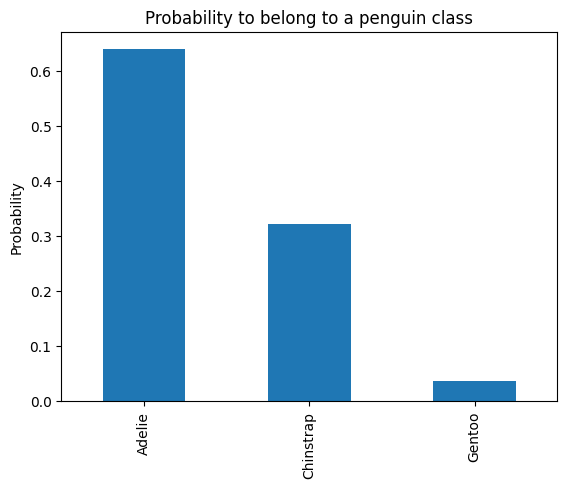

In [11]:
y_proba_class_0.plot.bar()
plt.ylabel("Probability")
_ = plt.title("Probability to belong to a penguin class")

We can also compute the different probabilities manually directly from the
tree structure.

In [12]:
adelie_proba = 103 / 161
chinstrap_proba = 52 / 161
gentoo_proba = 6 / 161
print(
    "Probabilities for the different classes:\n"
    f"Adelie: {adelie_proba:.3f}\n"
    f"Chinstrap: {chinstrap_proba:.3f}\n"
    f"Gentoo: {gentoo_proba:.3f}\n"
)

Probabilities for the different classes:
Adelie: 0.640
Chinstrap: 0.323
Gentoo: 0.037



It is also important to note that the culmen length has been disregarded for
the moment. It means that regardless of its value, it is not used during the
prediction.

In [13]:
test_penguin_3 = pd.DataFrame(
    {"Culmen Length (mm)": [10_000], "Culmen Depth (mm)": [17]}
)
tree.predict_proba(test_penguin_3)

array([[0.63975155, 0.32298137, 0.03726708]])

Going back to our classification problem, the split found with a maximum depth
of 1 is not powerful enough to separate the three species and the model
accuracy is low when compared to the linear model.

In [14]:
tree.fit(data_train, target_train)
test_score = tree.score(data_test, target_test)
print(f"Accuracy of the DecisionTreeClassifier: {test_score:.2f}")

Accuracy of the DecisionTreeClassifier: 0.78


Indeed, it is not a surprise. We saw earlier that a single feature is not able
to separate all three species: it underfits. However, from the previous
analysis we saw that by using both features we should be able to get fairly
good results.

In the next exercise, you will increase the tree depth to get an intuition on
how such a parameter affects the space partitioning.